# Table of contents
1. [Read Data](#read_data)
2. [Data Overview](#data_overview)
3. [Univariant analysis](#uni_analysis)
4. [Bivariate analysis](#bi_analysis)
5. [Modeling](#modeling)
    1. [Train-Test split](#train_test)
    2. [Preprocessing - Bucketing](#preproc)
    2. [Frequency model training](#freq_model)
    2. [Severity model training](#sev_model)
6. [Final price estimation](#final_price)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Auxiliar functions
import libafi_SGamez as libafi

# Dynamic plotting libraries
#! pip install plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

### Read data 

In [2]:
# Data comes from R CASdatasets
# In order to get the source data, it is needed to install CASdatasets
# Then run the following R lines:
# library(data.table)
# library(CASdatasets)
# data(freMTPLfreq)
# data(freMTPLsev)
# policy_dt <- copy(freMTPLfreq)
# claims_dt <- copy(freMTPLsev)
# setDT(policy_dt)
# setDT(claims_dt)
# fwrite(policy_dt, './data/policy_data.csv', sep='|')
# fwrite(claims_dt, './data/claims_data.csv', sep='|')

# Let's read the output csv with pandas
claims_data = pd.read_csv('../data/claims_data.csv', sep='|')
policy_data = pd.read_csv('../data/policy_data.csv', sep='|')

<a name="data_overview"></a>

## Data Overview

Data description from the R package. Available at:
https://github.com/dutangc/CASdatasets/blob/master/pkg/man/freMTPL.Rd

freMTPLfreq (policy data) contains 10 columns:

* PolicyID: The policy ID (used to link with the claims dataset).
* ClaimNb: Number of claims during the exposure period.
* Exposure: The period of exposure for a policy, in years.
* Power: The power of the car (ordered categorical).
* CarAge: The vehicle age, in years.
* DriverAge: The driver age, in years (in France, people can drive a car at 18).
* Brand: The car brand divided in the following groups: A- Renaut Nissan and Citroen, B- Volkswagen, Audi, Skoda and Seat, C- Opel, General Motors and Ford, D- Fiat, E- Mercedes Chrysler and BMW, F- Japanese (except Nissan) and Korean, G- other.
* Gas: The car gas, Diesel or regular.
* Region: The policy region in France (based on the 1970-2015 classification).
* Density: The density of inhabitants (number of inhabitants per km2) in the city the driver of the car lives in.

freMTPLsev contains 2 columns:

* PolicyID: The occurence date (used to link with the contract dataset).
* ClaimAmount: The cost of the claim, seen as at a recent date.

We will use freMTPLfreq data to train a frequency model, then freMTPLsev to train a serverity model

In [3]:
policy_data.head()

,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density
0,1,0,0.09,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76
1,2,0,0.84,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76
2,3,0,0.52,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003
3,4,0,0.45,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003
4,5,0,0.15,g,0,41,Japanese (except Nissan) or Korean,Diesel,Pays-de-la-Loire,60


In [4]:
claims_data.head()

,PolicyID,ClaimAmount
0,63987,1172
1,310037,1905
2,314463,1150
3,318713,1220
4,309380,55077


In [5]:
policy_data.shape, claims_data.shape

((413169, 10), (16181, 2))

In [6]:
# PolicyID is a key, not a feature
# ClaimNb is the target, handle it separately
# Exposure is not a feature either, it will also be handled separately
freq_target = 'ClaimNb'
col_exposure = 'Exposure'
sev_target = 'ClaimAmount'
features = [c for c in policy_data.columns if c not in  ['PolicyID', freq_target, col_exposure]]

In [7]:
# Describe features, and target column
policy_data[features + [col_exposure]].describe()

,CarAge,DriverAge,Density,Exposure
count,413169.000000,413169.000000,413169.000000,413169.000000
mean,7.532404,45.319876,1985.153913,0.561088
std,5.763011,14.328120,4776.254543,0.369477
min,0.000000,18.000000,2.000000,0.002732
25%,3.000000,34.000000,67.000000,0.200000
50%,7.000000,44.000000,287.000000,0.540000
75%,12.000000,54.000000,1410.000000,1.000000
max,100.000000,99.000000,27000.000000,1.990000


In [8]:
# The previous output does not capture the categorical features
# capture the categorical features, and re-run the describe
types = policy_data[features].dtypes
cat_features = types[types==object].index.values.tolist()
num_features = list(set(features) - set(cat_features))
cat_features, num_features

(['Power', 'Brand', 'Gas', 'Region'], ['DriverAge', 'CarAge', 'Density'])

In [9]:
policy_data[cat_features].describe()

,Power,Brand,Gas,Region
count,413169,413169,413169,413169
unique,12,7,2,10
top,f,"Renault, Nissan or Citroen",Regular,Centre
freq,95718,218200,207224,160601


In [10]:
# Review claim data
# we only have policy ID and claim amount
claims_data.describe()

,PolicyID,ClaimAmount
count,16181.000000,1.618100e+04
mean,185015.202151,2.129972e+03
std,117946.980398,2.106364e+04
min,33.000000,2.000000e+00
25%,83922.000000,6.980000e+02
50%,169907.000000,1.156000e+03
75%,281599.000000,1.243000e+03
max,412944.000000,2.036833e+06


<a name="uni_analysis"></a>

## Univariant analysis

/home/sgamez/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



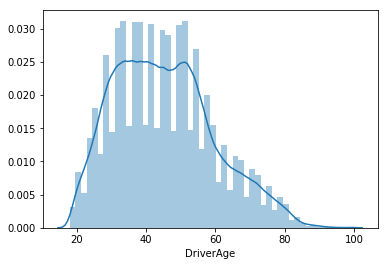

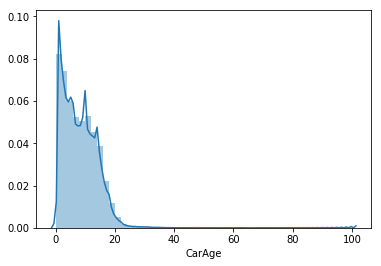

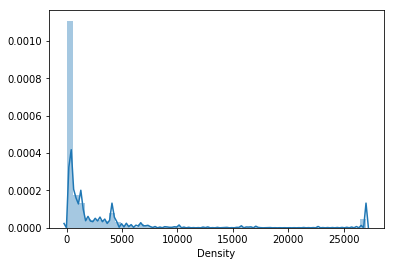

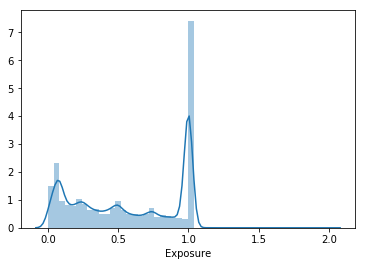

In [11]:
# Show distribution of numeric features
for num_feat in num_features + [col_exposure]:
    sns.distplot(policy_data[num_feat])
    plt.show()

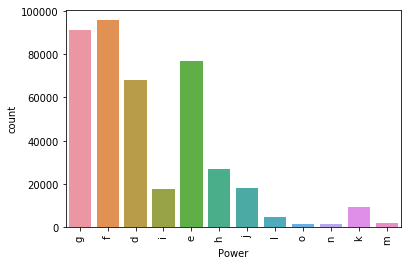

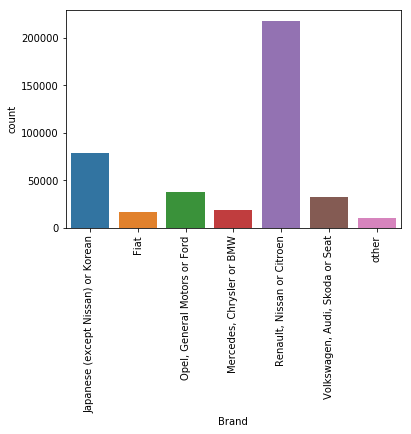

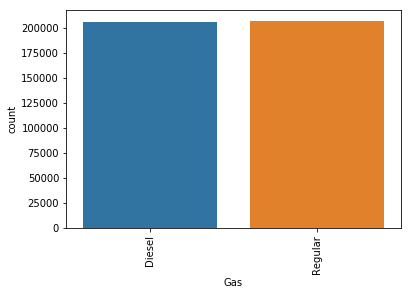

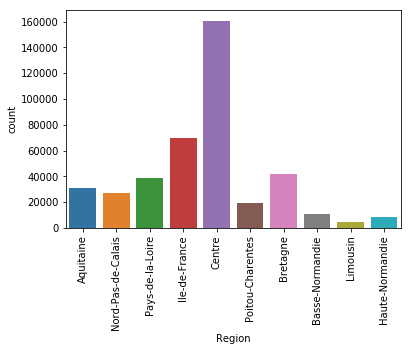

In [12]:
# Show distribution of categorical features
for cat_Feat in cat_features:
    sns.countplot(x=cat_Feat, data=policy_data)
    plt.xticks(rotation=90)
    plt.show()

/home/sgamez/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



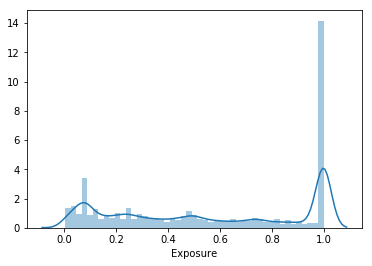

In [13]:
# One (of many possible) learning:
# Exposure has values higher than 1
# It could be a data quality issue
# Let's handle it
policy_data.loc[policy_data.Exposure > 1., 'Exposure'] = 1.
sns.distplot(policy_data['Exposure'])

In [14]:
# Is there any NA in our data?
policy_data.isna().sum()

PolicyID     0
ClaimNb      0
Exposure     0
Power        0
CarAge       0
DriverAge    0
Brand        0
Gas          0
Region       0
Density      0
dtype: int64

In [15]:
claims_data.isna().sum()

PolicyID       0
ClaimAmount    0
dtype: int64

In [16]:
# No, if there was we would have to follow some policy to fill them, like:
# - Fill NA with a value outside the range of the feature
# - Fill NA with the mean
# - Fill NA with a constant
# - Fill NA with the result of some sort of inference on that feature

Recommended tool: pandas_profiling, available at: https://github.com/pandas-profiling/pandas-profiling

In [17]:
# Run in case it needs to be installed
# ! pip install pandas_profiling
import pandas_profiling
profile = pandas_profiling.ProfileReport(policy_data)
profile

Number of variables,10
Number of observations,413169
Total Missing (%),0.0%
Total size in memory,31.5 MiB
Average record size in memory,80.0 B
Numeric,6
Categorical,4
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [18]:
# Output to html, so it can be shared
profile.to_file('../data/data_profile.html')

<a name="bi_analysis"></a>

## Bivariate analysis

### Numeric vs Numeric

/home/sgamez/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



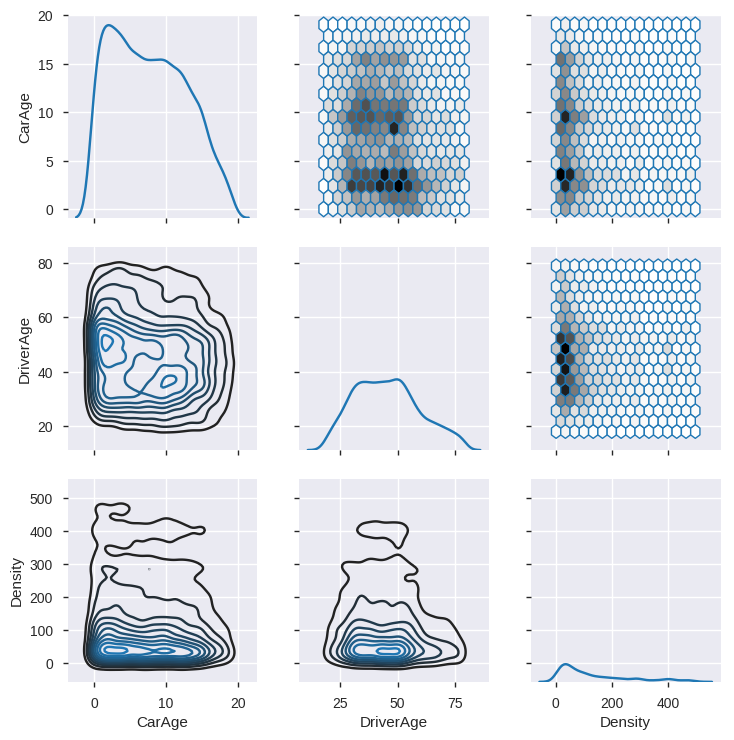

In [19]:
# Do some data filtering
# Otherwise the visualizations range are quite off
gridData = policy_data[features].sample(n=20000)
gridData = gridData.loc[gridData['CarAge'] < 20]
gridData = gridData.loc[gridData['DriverAge'] < 80]
gridData = gridData.loc[gridData['Density'] < 500]

g = sns.PairGrid(gridData)
g.map_upper(plt.hexbin, gridsize=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, legend=False)

In [20]:
# Correlation checks
corr = policy_data[features].sample(n=30000).corr()
corr

,CarAge,DriverAge,Density
CarAge,1.000000,-0.045993,-0.135268
DriverAge,-0.045993,1.000000,-0.002970
Density,-0.135268,-0.002970,1.000000


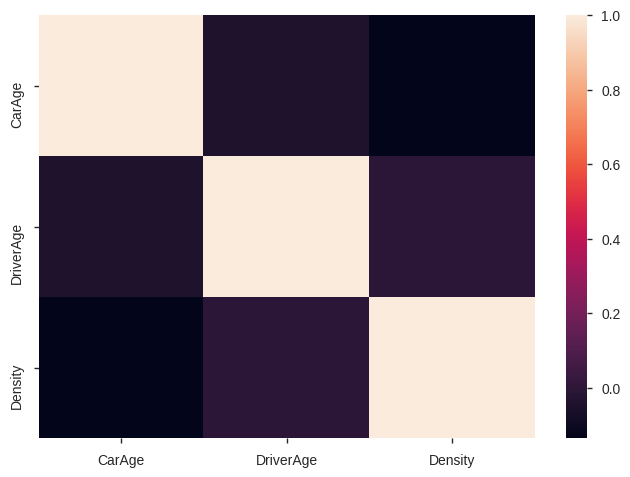

In [21]:
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### Numeric vs Categorical

/home/sgamez/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



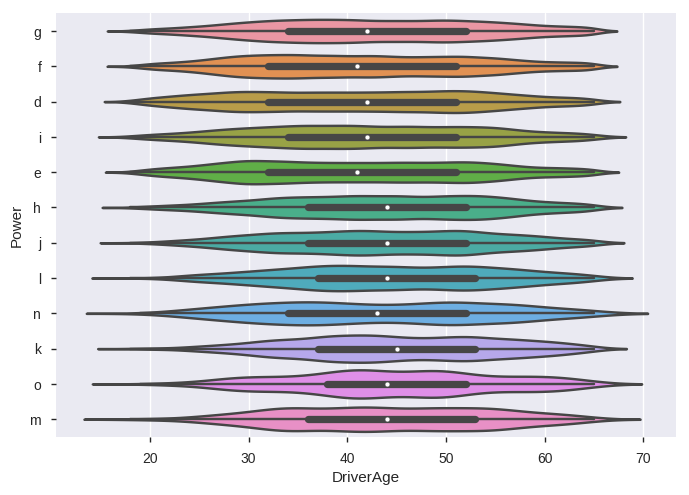

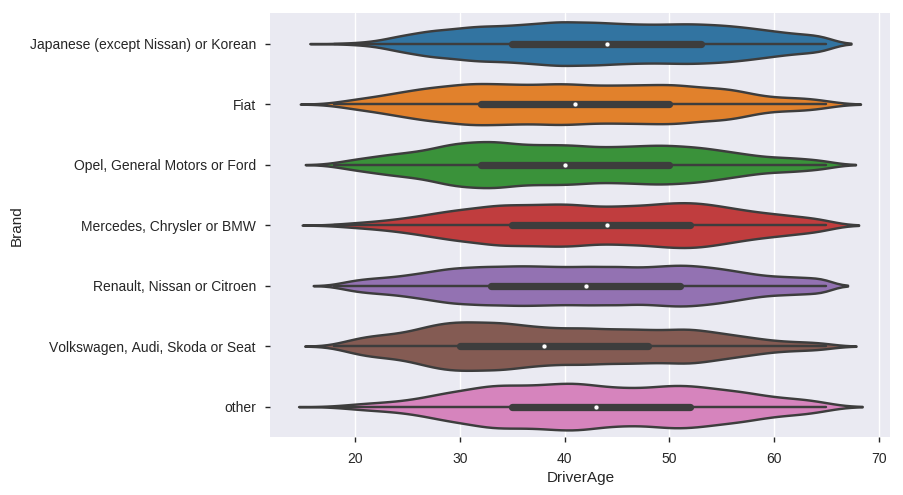

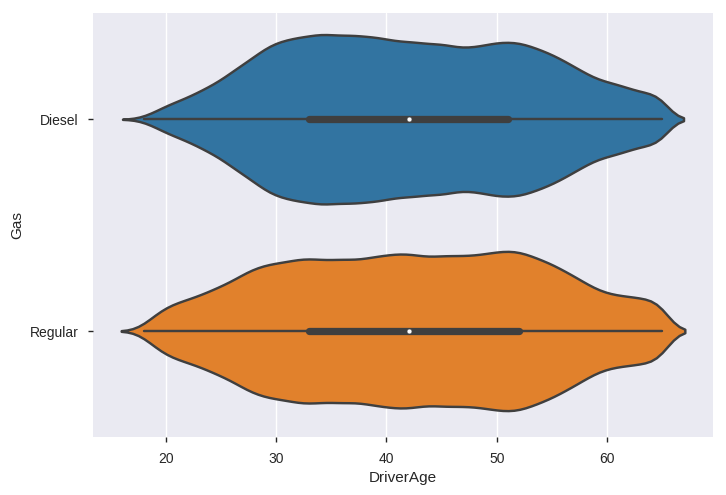

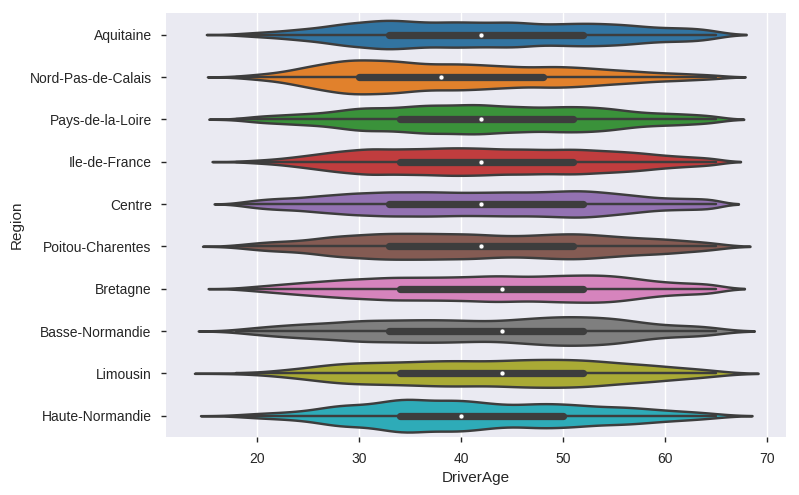

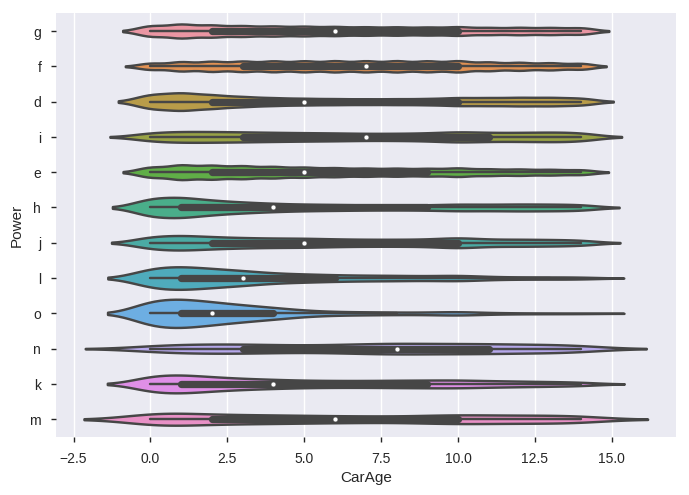

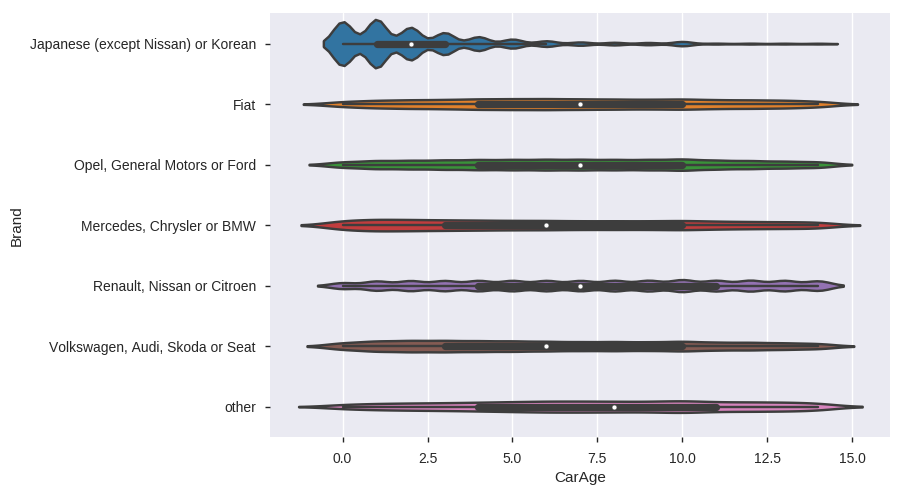

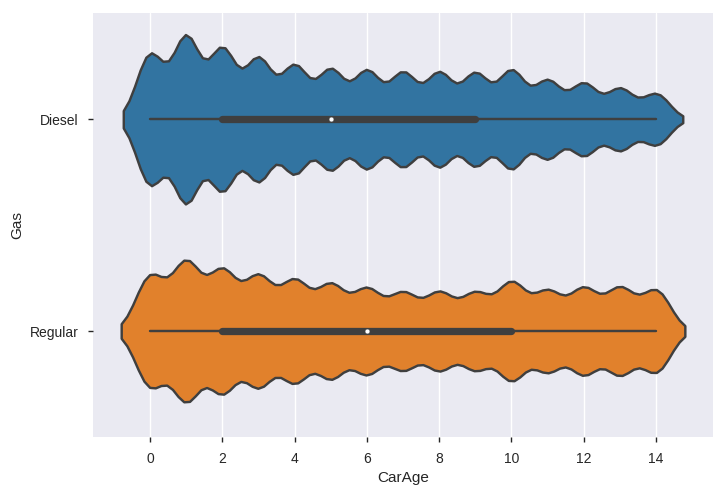

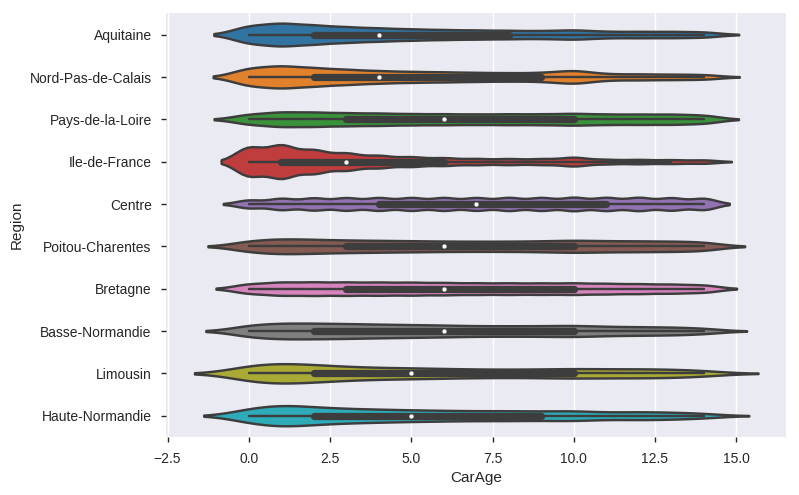

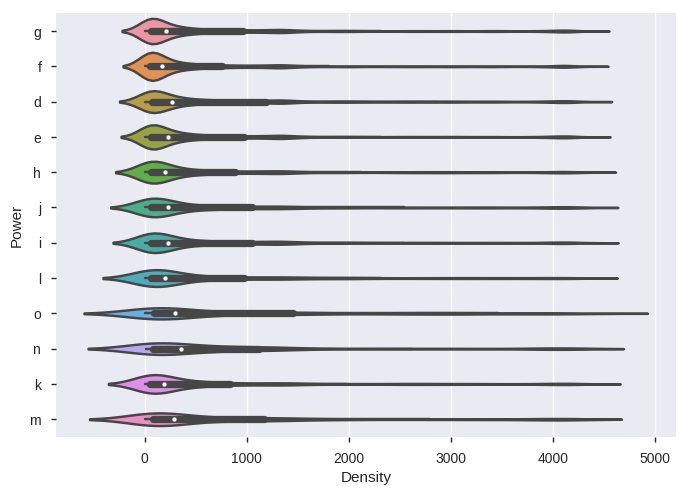

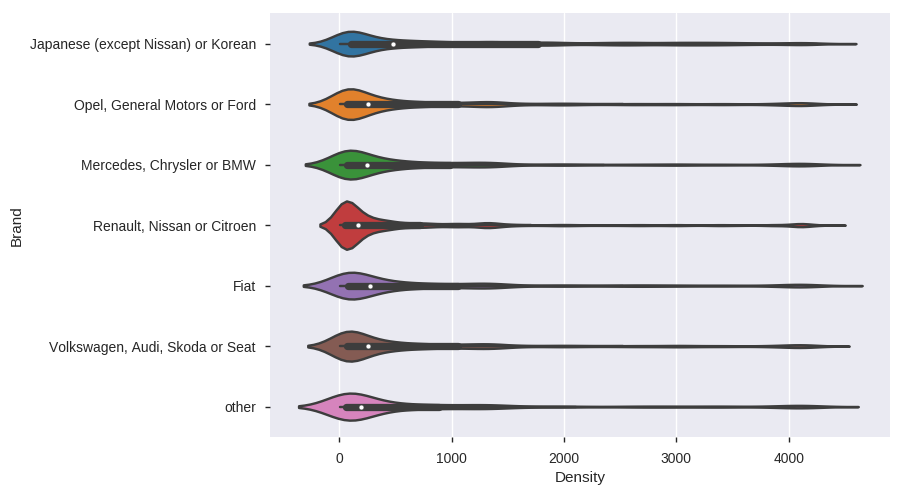

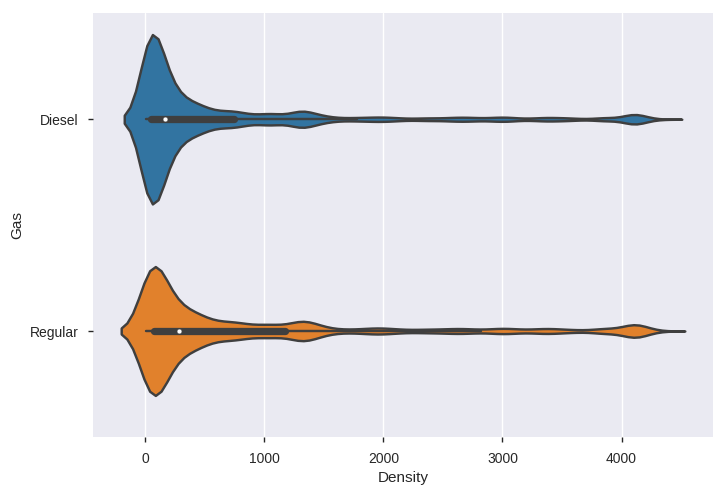

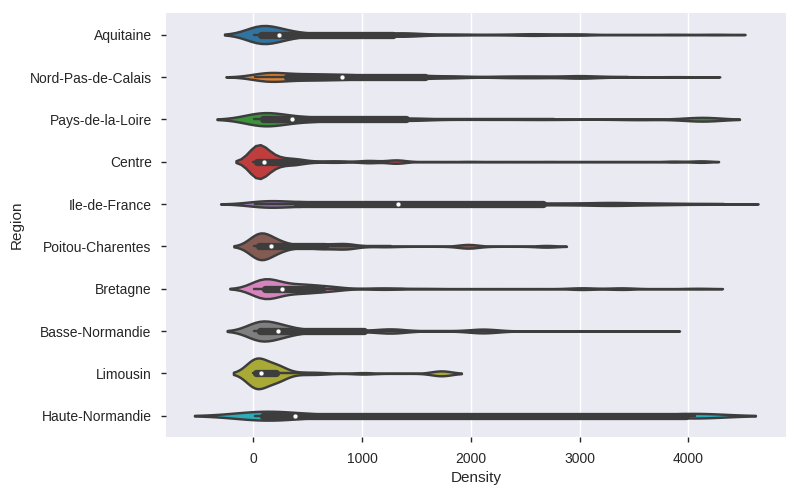

In [22]:
for num_feat in num_features:
    for cat_feat in cat_features:
        sns.violinplot(x=num_feat, y=cat_feat, kind="violin", data=policy_data.loc[policy_data[num_feat] < policy_data[num_feat].quantile(0.90)])
        plt.show()

### Categorical vs Categorical

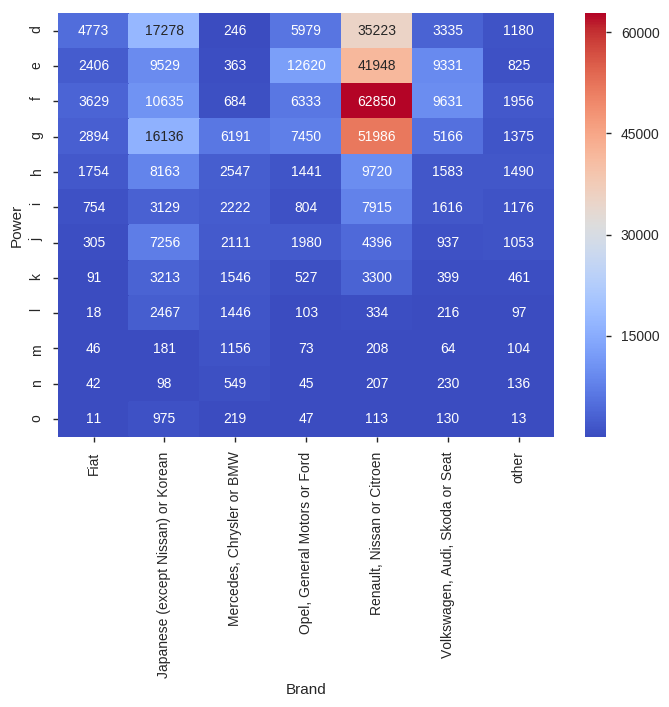

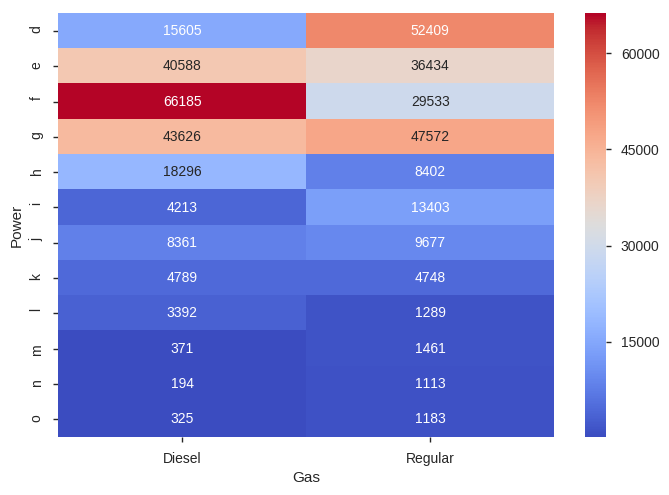

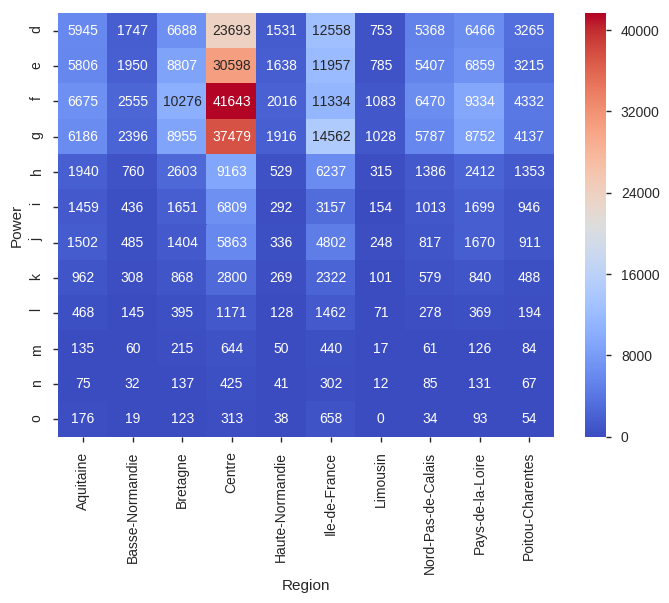

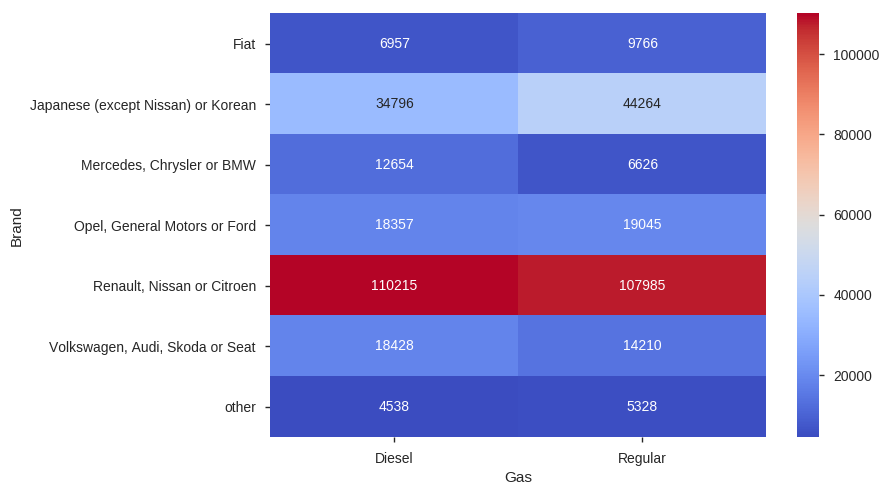

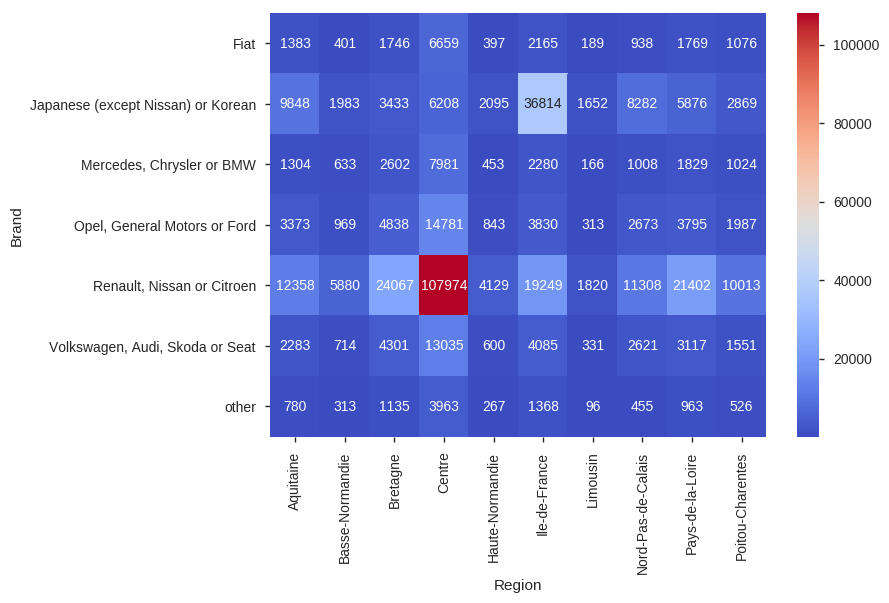

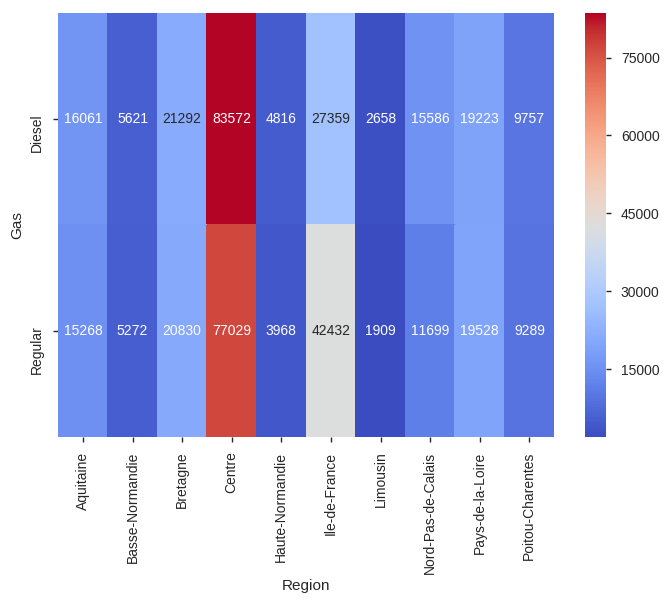

In [23]:
import itertools
cat_combinations = [a for a in itertools.combinations(cat_features, 2)]

for cat_comb in cat_combinations:
        sns.heatmap(pd.crosstab(policy_data[cat_comb[0]], policy_data[cat_comb[1]]),\
                    cmap='coolwarm', annot=True, fmt="d")
        plt.show()

### ETL in order to have a single data source 

In [24]:
claim_agg = claims_data.groupby('PolicyID').agg({'ClaimAmount': 'sum',
                                                 'PolicyID': 'count'})\
                                           .rename(columns={'PolicyID': 'N_claims_'})

In [25]:
claim_agg = claim_agg.reset_index()
claim_agg.head()

,PolicyID,ClaimAmount,N_claims_
0,33,302,1
1,41,2001,1
2,92,1449,1
3,96,10870,2
4,142,1390,1


In [26]:
flat_data = policy_data.merge(claim_agg, on='PolicyID', how='left')

In [27]:
flat_data.head()

,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density,ClaimAmount,N_claims_
0,1,0,0.09,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,NaN,NaN
1,2,0,0.84,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,NaN,NaN
2,3,0,0.52,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,NaN,NaN
3,4,0,0.45,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,NaN,NaN
4,5,0,0.15,g,0,41,Japanese (except Nissan) or Korean,Diesel,Pays-de-la-Loire,60,NaN,NaN


In [28]:
flat_data[['ClaimAmount', 'N_claims_']] = flat_data[['ClaimAmount', 'N_claims_']].fillna(0.) 

In [29]:
# Check to see if the ETL work correctly
(flat_data['ClaimNb'] - flat_data['N_claims_']).sum()

0.0

In [30]:
flat_data = flat_data.drop(columns='N_claims_')
flat_data.head()

,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density,ClaimAmount
0,1,0,0.09,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0.0
1,2,0,0.84,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0.0
2,3,0,0.52,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0.0
3,4,0,0.45,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0.0
4,5,0,0.15,g,0,41,Japanese (except Nissan) or Korean,Diesel,Pays-de-la-Loire,60,0.0


### Target Data Analysis

#### Frequency data

In [31]:
flat_data[freq_target].value_counts()

0    397779
1     14633
2       726
3        28
4         3
Name: ClaimNb, dtype: int64

In [32]:
100. * flat_data[freq_target].value_counts() / flat_data.shape[0]

0    96.275132
1     3.541650
2     0.175715
3     0.006777
4     0.000726
Name: ClaimNb, dtype: float64

In [33]:
100. * flat_data.groupby(flat_data[freq_target] > 0.).size() / flat_data.shape[0]

ClaimNb
False    96.275132
True      3.724868
dtype: float64

In [34]:
# Is 3.725% a high claim rate? Is is a good or a bad portfolio?

#### Severity data

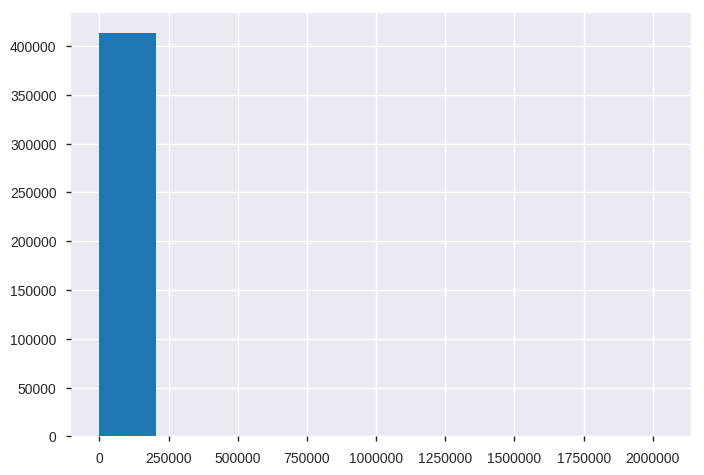

In [35]:
flat_data[sev_target].hist()

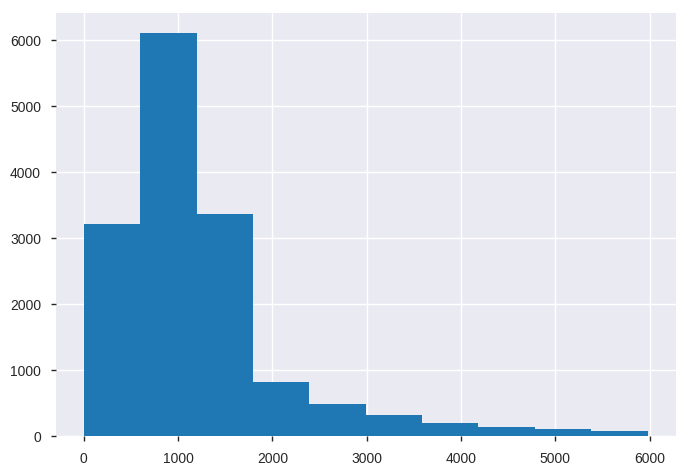

In [36]:
flat_data.loc[(flat_data[sev_target] > 0.) & (flat_data[sev_target] < 6000.)][sev_target].hist()

(array([0.000e+00, 6.000e+00, 6.000e+00, 1.400e+01, 3.100e+01, 5.000e+01,
        1.360e+02, 8.160e+02, 3.700e+02, 5.710e+02, 9.260e+02, 1.535e+03,
        8.205e+03, 1.439e+03, 7.210e+02, 2.780e+02, 1.390e+02, 5.600e+01,
        3.800e+01, 2.900e+01, 1.000e+01, 1.200e+01, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00]),
 array([1.00000000e+00, 1.77827941e+00, 3.16227766e+00, 5.62341325e+00,
        1.00000000e+01, 1.77827941e+01, 3.16227766e+01, 5.62341325e+01,
        1.00000000e+02, 1.77827941e+02, 3.16227766e+02, 5.62341325e+02,
        1.00000000e+03, 1.77827941e+03, 3.16227766e+03, 5.62341325e+03,
        1.00000000e+04, 1.77827941e+04, 3.16227766e+04, 5.62341325e+04,
        1.00000000e+05, 1.77827941e+05, 3.16227766e+05, 5.62341325e+05,
        1.00000000e+06, 1.77827941e+06, 3.16227766e+06, 5.62341325e+06]),
 <a list of 27 Patch objects>)

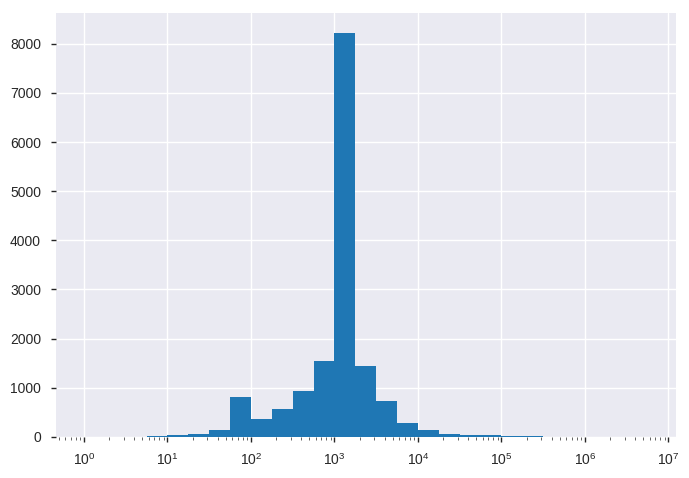

In [37]:
data = [1.2, 14, 150 ]
bins = 10**(np.arange(0, 7, 0.25))
plt.xscale('log')
plt.hist(flat_data.loc[flat_data[sev_target] > 0.][sev_target],bins=bins) 

### Feature analysis versus target data

In [38]:
# Example to cut data
libafi.get_cut_df('CarAge', [0, 95], 5, flat_data, freq_target)

(            cuts       N        BR
 0  (-0.001, 3.4]  129023  0.033087
 1     (3.4, 6.8]   72048  0.043568
 2    (6.8, 10.2]   86989  0.045891
 3   (10.2, 13.6]   56995  0.043214
 4   (13.6, 17.0]   50198  0.036077, 0.0396556129871247)

In [39]:
# Example ploting feature behaviour
py.iplot(libafi.output_graph_update('CarAge', [0, 95], 7, flat_data, freq_target))

#### Feature behaviour versus frequency

In [40]:
for feat in features:
    py.iplot(libafi.output_graph_update(feat, [0, 95], 7, flat_data, freq_target))

#### Feature behaviour versus severity

In [41]:
for feat in features:
    py.iplot(libafi.output_graph_update(feat, [0, 95], 7, flat_data, sev_target))

<a name="modeling"></a>

## Modelling

<a name="train_test"></a>

### Train - Test split

In [42]:
flat_data_tr = flat_data.sample(frac = 0.7, random_state=42)
flat_data_test = flat_data[~flat_data.index.isin(flat_data_tr.index)]

In [43]:
len(flat_data), len(flat_data_tr), len(flat_data_test)

(413169, 289218, 123951)

In [44]:
print (flat_data[[freq_target, sev_target]].mean()) 
print (flat_data_tr[[freq_target, sev_target]].mean())
print (flat_data_test[[freq_target, sev_target]].mean()) 

ClaimNb         0.039163
ClaimAmount    83.416416
dtype: float64
ClaimNb         0.039216
ClaimAmount    81.074518
dtype: float64
ClaimNb         0.039040
ClaimAmount    88.880824
dtype: float64


<a name="preproc"></a>

### Preprocessing - Bucketing

In [45]:
# ! pip install -U scikit-learn

In [46]:
# Need sklearn version > 0.20
import sklearn
sklearn.__version__

'0.20.3'

#### Handle Numeric features

In [47]:
# Numeric preprocessing set-up
# kmeans / balanced discretization strategies
? libafi.setup_numeric_prepoc

In [48]:
# Tree based discretization strategy
? libafi.setup_numtree_prepoc

In [49]:
# Using a K-means bucketing strategy
dict_enc_num_kmeans = libafi.setup_numeric_prepoc(flat_data_tr, num_features, 7, 'kmeans')
dict_enc_num_kmeans

{'DriverAge': {'enc': KBinsDiscretizer(encode='onehot-dense', n_bins=7, strategy='kmeans'),
  'col_names': ['DriverAge_18.0_31.6',
   'DriverAge_31.6_41.3',
   'DriverAge_41.3_50.2',
   'DriverAge_50.2_59.1',
   'DriverAge_59.1_68.1',
   'DriverAge_68.1_77.0',
   'DriverAge_77.0_99.0'],
  'col_names_drop': ['DriverAge_31.6_41.3',
   'DriverAge_41.3_50.2',
   'DriverAge_50.2_59.1',
   'DriverAge_59.1_68.1',
   'DriverAge_68.1_77.0',
   'DriverAge_77.0_99.0']},
 'CarAge': {'enc': KBinsDiscretizer(encode='onehot-dense', n_bins=7, strategy='kmeans'),
  'col_names': ['CarAge_0.0_6.1',
   'CarAge_6.1_12.0',
   'CarAge_12.0_17.1',
   'CarAge_17.1_24.1',
   'CarAge_24.1_36.2',
   'CarAge_36.2_69.4',
   'CarAge_69.4_100.0'],
  'col_names_drop': ['CarAge_6.1_12.0',
   'CarAge_12.0_17.1',
   'CarAge_17.1_24.1',
   'CarAge_24.1_36.2',
   'CarAge_36.2_69.4',
   'CarAge_69.4_100.0']},
 'Density': {'enc': KBinsDiscretizer(encode='onehot-dense', n_bins=7, strategy='kmeans'),
  'col_names': ['Density_2

In [50]:
# Using a quantile bucketing strategy
dict_enc_num_quant = libafi.setup_numeric_prepoc(flat_data_tr, num_features, 10, 'quantile')
dict_enc_num_quant

{'DriverAge': {'enc': KBinsDiscretizer(encode='onehot-dense', n_bins=10, strategy='quantile'),
  'col_names': ['DriverAge_18.0_28.0',
   'DriverAge_28.0_32.0',
   'DriverAge_32.0_36.0',
   'DriverAge_36.0_40.0',
   'DriverAge_40.0_44.0',
   'DriverAge_44.0_48.0',
   'DriverAge_48.0_52.0',
   'DriverAge_52.0_57.0',
   'DriverAge_57.0_66.0',
   'DriverAge_66.0_99.0'],
  'col_names_drop': ['DriverAge_28.0_32.0',
   'DriverAge_32.0_36.0',
   'DriverAge_36.0_40.0',
   'DriverAge_40.0_44.0',
   'DriverAge_44.0_48.0',
   'DriverAge_48.0_52.0',
   'DriverAge_52.0_57.0',
   'DriverAge_57.0_66.0',
   'DriverAge_66.0_99.0']},
 'CarAge': {'enc': KBinsDiscretizer(encode='onehot-dense', n_bins=10, strategy='quantile'),
  'col_names': ['CarAge_0.0_1.0',
   'CarAge_1.0_2.0',
   'CarAge_2.0_3.0',
   'CarAge_3.0_5.0',
   'CarAge_5.0_7.0',
   'CarAge_7.0_9.0',
   'CarAge_9.0_11.0',
   'CarAge_11.0_13.0',
   'CarAge_13.0_15.0',
   'CarAge_15.0_100.0'],
  'col_names_drop': ['CarAge_1.0_2.0',
   'CarAge_2.0

In [51]:
dict_enc_num_trees = libafi.setup_numtree_prepoc(flat_data_tr, num_features, col_exposure, freq_target)
dict_enc_num_trees

{'DriverAge': {'thresholds': [-inf,
   18.5,
   19.5,
   20.5,
   21.5,
   22.5,
   23.5,
   25.5,
   26.5,
   31.5,
   42.5,
   51.5,
   inf]},
 'CarAge': {'thresholds': [-inf,
   0.5,
   1.5,
   3.5,
   7.5,
   12.5,
   14.5,
   16.5,
   17.5,
   25.5,
   26.5,
   83.5,
   inf]},
 'Density': {'thresholds': [-inf,
   11.5,
   19.5,
   20.5,
   43.5,
   137.5,
   203.5,
   238.5,
   404.5,
   434.5,
   443.0,
   464.0,
   922.0,
   4073.0,
   4119.5,
   16287.5,
   inf]}}

In [52]:
# Preprocess with tree based strategy
num_tree_tr, num_tree_cols = libafi.apply_treepreproc(dict_enc_num_trees, flat_data_tr)
num_tree_test, _ = libafi.apply_treepreproc(dict_enc_num_trees, flat_data_test)

/home/sgamez/work/afi/Pycode/libafi_SGamez.py:78: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/sgamez/work/afi/Pycode/libafi_SGamez.py:78: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/sgamez/work/afi/Pycode/libafi_SGamez.py:78: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [53]:
num_tree_tr.shape, num_tree_test.shape

((289218, 37), (123951, 37))

In [54]:
len(num_tree_cols)

37

#### Handle categorical features

In [55]:
for cat_feature in cat_features:
    display(100. * flat_data_tr[cat_feature].value_counts() / len(flat_data_tr))

f    23.113707
g    22.020414
e    18.701118
d    16.442960
h     6.473663
j     4.418812
i     4.263566
k     2.310368
l     1.129252
m     0.453291
o     0.356479
n     0.316370
Name: Power, dtype: float64

Renault, Nissan or Citroen            52.767117
Japanese (except Nissan) or Korean    19.200741
Opel, General Motors or Ford           9.051304
Volkswagen, Audi, Skoda or Seat        7.895428
Mercedes, Chrysler or BMW              4.650471
Fiat                                   4.021880
other                                  2.413059
Name: Brand, dtype: float64

Regular    50.257245
Diesel     49.742755
Name: Gas, dtype: float64

Centre                38.873791
Ile-de-France         16.923566
Bretagne              10.138719
Pays-de-la-Loire       9.400176
Aquitaine              7.576983
Nord-Pas-de-Calais     6.614734
Poitou-Charentes       4.632838
Basse-Normandie        2.594237
Haute-Normandie        2.137142
Limousin               1.107815
Name: Region, dtype: float64

In [56]:
dict_enc_cat = libafi.setup_categoric_prepoc(flat_data_tr, cat_features, 2.5)
dict_enc_cat

{'Power': {'others': ['k', 'l', 'm', 'o', 'n'],
  'enc': OneHotEncoder(categorical_features=None, categories=None,
         dtype=<class 'numpy.float64'>, handle_unknown='error',
         n_values=None, sparse=False),
  'col_names': ['Power_Other',
   'Power_d',
   'Power_e',
   'Power_f',
   'Power_g',
   'Power_h',
   'Power_i',
   'Power_j'],
  'col_names_drop': ['Power_d',
   'Power_e',
   'Power_f',
   'Power_g',
   'Power_h',
   'Power_i',
   'Power_j']},
 'Brand': {'others': ['other'],
  'enc': OneHotEncoder(categorical_features=None, categories=None,
         dtype=<class 'numpy.float64'>, handle_unknown='error',
         n_values=None, sparse=False),
  'col_names': ['Brand_Fiat',
   'Brand_Japane',
   'Brand_Merced',
   'Brand_Opel, ',
   'Brand_Other',
   'Brand_Renaul',
   'Brand_Volksw'],
  'col_names_drop': ['Brand_Japane',
   'Brand_Merced',
   'Brand_Opel, ',
   'Brand_Other',
   'Brand_Renaul',
   'Brand_Volksw']},
 'Gas': {'others': [],
  'enc': OneHotEncoder(categoric

In [57]:
cat_enc_tr, cat_cols, cat_cols_drop = libafi.apply_encoding(dict_enc_cat, flat_data_tr)
cat_enc_test, _, _ = libafi.apply_encoding(dict_enc_cat, flat_data_test)

/home/sgamez/work/afi/Pycode/libafi_SGamez.py:133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/sgamez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/sgamez/work/afi/Pycode/libafi_SGamez.py:133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [58]:
len(cat_cols), len(cat_cols_drop)

(26, 22)

In [59]:
flat_data_tr.Power.value_counts()

f    66849
g    63687
e    54087
d    47556
h    18723
j    12780
i    12331
k     6682
l     3266
m     1311
o     1031
n      915
Name: Power, dtype: int64

In [60]:
cat_cols_drop[:5]

['Power_d', 'Power_e', 'Power_f', 'Power_g', 'Power_h']

In [61]:
cat_enc_tr[:, :5].sum(axis=0)

array([47556., 54087., 66849., 63687., 18723.])

In [62]:
flat_data_tr.Region_other.value_counts()

Centre                112430
Ile-de-France          48946
Bretagne               29323
Pays-de-la-Loire       27187
Aquitaine              21914
Nord-Pas-de-Calais     19131
Poitou-Charentes       13399
Other                   9385
Basse-Normandie         7503
Name: Region_other, dtype: int64

In [63]:
cat_cols_drop[-5:]

['Region_Ile-de',
 'Region_Nord-P',
 'Region_Other',
 'Region_Pays-d',
 'Region_Poitou']

In [64]:
cat_enc_tr[:, -5:].sum(axis=0)

array([48946., 19131.,  9385., 27187., 13399.])

In [65]:
cat_enc_tr.shape, cat_enc_test.shape

((289218, 22), (123951, 22))

#### Merge both categorical and numerical processed train and test data

In [66]:
# Operative column names, with the firt bucket being previously removed
col_names = cat_cols_drop + num_tree_cols
X_tr = pd.DataFrame(np.concatenate([cat_enc_tr, num_tree_tr], axis=1), columns=col_names)
X_test = pd.DataFrame(np.concatenate([cat_enc_test, num_tree_test], axis=1), columns=col_names)
Y_freq_tr, Y_sev_tr = flat_data_tr[freq_target].reset_index(drop=True), flat_data_tr[sev_target].reset_index(drop=True)
Y_freq_test, Y_sev_test = flat_data_test[freq_target].reset_index(drop=True), flat_data_test[sev_target].reset_index(drop=True)

### Serialize preprocessing

In [67]:
# Example about how to serialize preprocessing, so it could be used
# in later modeling phases, or production
import pickle
# Put together categorical and numerical preprocessing
preproc = {'cat': dict_enc_cat,
           'tree': dict_enc_num_trees}
pickle.dump(preproc, open('../data/preproc.pkl', 'wb'))

In [68]:
load_preproc = pickle.load(open('../data/preproc.pkl', 'rb'))
load_preproc

{'cat': {'Power': {'others': ['k', 'l', 'm', 'o', 'n'],
   'enc': OneHotEncoder(categorical_features=None, categories=None,
          dtype=<class 'numpy.float64'>, handle_unknown='error',
          n_values=None, sparse=False),
   'col_names': ['Power_Other',
    'Power_d',
    'Power_e',
    'Power_f',
    'Power_g',
    'Power_h',
    'Power_i',
    'Power_j'],
   'col_names_drop': ['Power_d',
    'Power_e',
    'Power_f',
    'Power_g',
    'Power_h',
    'Power_i',
    'Power_j']},
  'Brand': {'others': ['other'],
   'enc': OneHotEncoder(categorical_features=None, categories=None,
          dtype=<class 'numpy.float64'>, handle_unknown='error',
          n_values=None, sparse=False),
   'col_names': ['Brand_Fiat',
    'Brand_Japane',
    'Brand_Merced',
    'Brand_Opel, ',
    'Brand_Other',
    'Brand_Renaul',
    'Brand_Volksw'],
   'col_names_drop': ['Brand_Japane',
    'Brand_Merced',
    'Brand_Opel, ',
    'Brand_Other',
    'Brand_Renaul',
    'Brand_Volksw']},
  'Gas': {'o

<a name="freq_model"></a>

### Frequency model training

#### GLM based models

In [69]:
# Using statsmodel to train models
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, roc_auc_score

# Poisson model to train the frequency model
# using exposure to weight observations
freq_glm_model = sm.GLM(Y_freq_tr, sm.add_constant(X_tr), family=sm.families.Poisson(), exposure=np.asarray(flat_data_tr[col_exposure]))

freq_glm_fitted = freq_glm_model.fit()
print(freq_glm_fitted.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               289218
Model:                            GLM   Df Residuals:                   289158
Model Family:                 Poisson   Df Model:                           59
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47200.
Date:                Mon, 20 May 2019   Deviance:                       72480.
Time:                        10:22:51   Pearson chi2:                 5.14e+05
No. Iterations:                     7   Covariance Type:             nonrobust
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1.0214      0.211     -4.839      0.000      -1.435      -0.608
Power_d         

In [70]:
# Predicting using exposure parameter
pred_tr = freq_glm_fitted.predict(sm.add_constant(X_tr), exposure=np.asarray(flat_data_tr[col_exposure]))
pred_test = freq_glm_fitted.predict(sm.add_constant(X_test), exposure=np.asarray(flat_data_test[col_exposure]))

In [71]:
def summary_model_performance(Y_train, Y_test, pred_train, pred_test, model_name, AUC = True):
    """Generates a small model performance summary
    
    Args:
        Y_train: Target data for train sample
        Y_test: Target data for test sample
        pred_train: Train predictions
        pred_test: Test predictions
        
    Returns:
        Pandas DataFrame with summarized performance data
    """
    summary = {'Model': model_name,
               'Sample': ['Train', 'Test'],
               'MSE': [mean_squared_error(Y_train, pred_train), mean_squared_error(Y_test, pred_test)],
               'MAE': [mean_absolute_error(Y_train, pred_train), mean_absolute_error(Y_test, pred_test)]}
    # We are working with regression models
    # AUC should not be a metric to measure
    # but we are going to asses the frecuency target
    # as 'has claim' vs 'has no claim'
    if AUC:
        summary['AUC'] = [roc_auc_score(Y_train>0, pred_train), roc_auc_score(Y_test>0, pred_test)]
    df = pd.DataFrame(summary)
    return df

In [72]:
glm_tree_perf = summary_model_performance(Y_freq_tr, Y_freq_test, pred_tr, pred_test, 'GLM_tree')
glm_tree_perf

,Model,Sample,MSE,MAE,AUC
0,GLM_tree,Train,0.041267,0.074318,0.654926
1,GLM_tree,Test,0.041269,0.074200,0.652611


In [73]:
# Try alternative preprocessing
# - Kmeans discretization
num_kmeans_tr, _, num_kmeans_cols = libafi.apply_encoding(dict_enc_num_kmeans, flat_data_tr)
num_kmeans_test, _, _ = libafi.apply_encoding(dict_enc_num_kmeans, flat_data_test)
col_names_kmeans = cat_cols_drop + num_kmeans_cols
X_tr_kmeans = pd.DataFrame(np.concatenate([cat_enc_tr, num_kmeans_tr], axis=1), columns=col_names_kmeans)
X_test_kmeans = pd.DataFrame(np.concatenate([cat_enc_test, num_kmeans_test], axis=1), columns=col_names_kmeans)
# Train
freq_glm_model_km = sm.GLM(Y_freq_tr, sm.add_constant(X_tr_kmeans), family=sm.families.Poisson(), exposure=np.asarray(flat_data_tr[col_exposure]))
freq_glm_km_fitted = freq_glm_model_km.fit()
# Predict 
pred_tr_kmeans = freq_glm_km_fitted.predict(sm.add_constant(X_tr_kmeans), exposure=np.asarray(flat_data_tr[col_exposure]))
pred_test_kmeans = freq_glm_km_fitted.predict(sm.add_constant(X_test_kmeans), exposure=np.asarray(flat_data_test[col_exposure]))
glm_kmeans_perf = summary_model_performance(Y_freq_tr, Y_freq_test, pred_tr_kmeans, pred_test_kmeans, 'GLM_kmeans')
glm_kmeans_perf

,Model,Sample,MSE,MAE,AUC
0,GLM_kmeans,Train,0.041375,0.074527,0.641964
1,GLM_kmeans,Test,0.041354,0.074394,0.640833


In [74]:
# - Balanced discretization
num_quant_tr, _, num_quant_cols = libafi.apply_encoding(dict_enc_num_quant, flat_data_tr)
num_quant_test, _, _ = libafi.apply_encoding(dict_enc_num_quant, flat_data_test)
col_names_quant = cat_cols_drop + num_quant_cols
X_tr_quant = pd.DataFrame(np.concatenate([cat_enc_tr, num_quant_tr], axis=1), columns=col_names_quant)
X_test_quant = pd.DataFrame(np.concatenate([cat_enc_test, num_quant_test], axis=1), columns=col_names_quant)
# Train
freq_glm_model_quant = sm.GLM(Y_freq_tr, sm.add_constant(X_tr_quant), family=sm.families.Poisson(), exposure=np.asarray(flat_data_tr[col_exposure]))
freq_glm_quant_fitted = freq_glm_model_quant.fit()
# Predict 
pred_tr_quant = freq_glm_quant_fitted.predict(sm.add_constant(X_tr_quant), exposure=np.asarray(flat_data_tr[col_exposure]))
pred_test_quant = freq_glm_quant_fitted.predict(sm.add_constant(X_test_quant), exposure=np.asarray(flat_data_test[col_exposure]))
glm_quant_perf = summary_model_performance(Y_freq_tr, Y_freq_test, pred_tr_quant, pred_test_quant, 'GLM_quant')
glm_quant_perf

,Model,Sample,MSE,MAE,AUC
0,GLM_quant,Train,0.041323,0.074435,0.648602
1,GLM_quant,Test,0.041311,0.074309,0.648002


#### Ensemble based models

##### Random Forest

In [75]:
# RF Regressor
from sklearn.ensemble import RandomForestRegressor
col_names_rf = cat_cols_drop + num_features
X_tr_rf = pd.DataFrame(np.concatenate([cat_enc_tr, flat_data_tr[num_features]], axis=1), columns=col_names_rf)
X_test_rf = pd.DataFrame(np.concatenate([cat_enc_test, flat_data_test[num_features]], axis=1), columns=col_names_rf)

rf_ = RandomForestRegressor(n_estimators=400, 
                           max_depth=5, 
                           min_samples_split=300, 
                           n_jobs=4)

rf_.fit(X_tr_rf, Y_freq_tr)
pred_tr_rf_ = rf_.predict(X_tr_rf)
pred_test_rf_ = rf_.predict(X_test_rf)
rf_base_perf = summary_model_performance(Y_freq_tr, Y_freq_test, pred_tr_rf_, pred_test_rf_, 'RF_base')
rf_base_perf

,Model,Sample,MSE,MAE,AUC
0,RF_base,Train,0.041452,0.075223,0.593312
1,RF_base,Test,0.041500,0.075116,0.580214


In [76]:
# What about exposure?
# could be considered a feature
# could also be considered as a sample weight 
col_names_rf = cat_cols_drop + num_features + [col_exposure]
X_tr_exp = pd.DataFrame(np.concatenate([cat_enc_tr, flat_data_tr[num_features + [col_exposure]]], axis=1), columns=col_names_rf)
X_test_exp = pd.DataFrame(np.concatenate([cat_enc_test, flat_data_test[num_features + [col_exposure]]], axis=1), columns=col_names_rf)

rf_ = RandomForestRegressor(n_estimators=400, 
                           max_depth=5, 
                           min_samples_split=300, 
                           n_jobs=4)

rf_.fit(X_tr_exp, Y_freq_tr)
pred_tr_rf_exp = rf_.predict(X_tr_exp)
pred_test_rf_exp = rf_.predict(X_test_exp)
rf_exp_perf = summary_model_performance(Y_freq_tr, Y_freq_test, pred_tr_rf_exp, pred_test_rf_exp, 'RF_exposure')
rf_exp_perf

,Model,Sample,MSE,MAE,AUC
0,RF_exposure,Train,0.041139,0.074664,0.661227
1,RF_exposure,Test,0.041171,0.074559,0.657821


##### Gradient Boosting - XGBoost

In [77]:
from xgboost import XGBRegressor

xgb = XGBRegressor(max_depth = 4,
                   learning_rate = 0.05,
                   n_estimators = 200,
                   n_jobs = 4)

xgb.fit(X_tr_rf, Y_freq_tr)
pred_tr_xgb = xgb.predict(X_tr_rf)
pred_test_xgb = xgb.predict(X_test_rf)
xgb_base_perf = summary_model_performance(Y_freq_tr, Y_freq_test, pred_tr_xgb, pred_test_xgb, 'XGB_base')
xgb_base_perf

/home/sgamez/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



,Model,Sample,MSE,MAE,AUC
0,XGB_base,Train,0.041256,0.075005,0.621139
1,XGB_base,Test,0.041467,0.075042,0.592671


In [78]:
# Also consider exposure as feature
xgb = XGBRegressor(max_depth = 4,
                   learning_rate = 0.05,
                   n_estimators = 200,
                   n_jobs = 4)

xgb.fit(X_tr_exp, Y_freq_tr)
pred_tr_xgb_exp = xgb.predict(X_tr_exp)
pred_test_xgb_exp = xgb.predict(X_test_exp)
xgb_exp_perf = summary_model_performance(Y_freq_tr, Y_freq_test, pred_tr_xgb_exp, pred_test_xgb_exp, 'XGB_exposure')
xgb_exp_perf

/home/sgamez/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



,Model,Sample,MSE,MAE,AUC
0,XGB_exposure,Train,0.040904,0.074389,0.683285
1,XGB_exposure,Test,0.041104,0.074383,0.668245


##### Review performance of all models

In [79]:
df_perf_freq = pd.concat([glm_tree_perf, glm_kmeans_perf, glm_quant_perf,
                          rf_base_perf, rf_exp_perf,
                          xgb_base_perf, xgb_exp_perf])

#Show test set performance for all models
df_perf_freq.loc[df_perf_freq.Sample=='Test'][[c for c in df_perf_freq.columns if c!= 'Sample']]

,Model,MSE,MAE,AUC
1,GLM_tree,0.041269,0.074200,0.652611
1,GLM_kmeans,0.041354,0.074394,0.640833
1,GLM_quant,0.041311,0.074309,0.648002
1,RF_base,0.041500,0.075116,0.580214
1,RF_exposure,0.041171,0.074559,0.657821
1,XGB_base,0.041467,0.075042,0.592671
1,XGB_exposure,0.041104,0.074383,0.668245


<a name="sev_model"></a>

### Severity model training

In [80]:
# Re-apply tree based bucketing 
# Using the severity as target
dict_enc_numfreq_trees = libafi.setup_numtree_prepoc(flat_data_tr, num_features, col_exposure, sev_target, max_depth=3)
num_treefreq_tr, num_treefreq_cols = libafi.apply_treepreproc(dict_enc_numfreq_trees, flat_data_tr)
num_treefreq_test, _ = libafi.apply_treepreproc(dict_enc_numfreq_trees, flat_data_test)

# Actual target is amount per claim
flat_data_tr['Amnt_per_claim'] = flat_data_tr['ClaimAmount'] / flat_data_tr['ClaimNb']
flat_data_tr['Amnt_per_claim'] = flat_data_tr['Amnt_per_claim'].fillna(0.)
flat_data_test['Amnt_per_claim'] = flat_data_test['ClaimAmount'] / flat_data_test['ClaimNb']
flat_data_test['Amnt_per_claim'] = flat_data_test['Amnt_per_claim'].fillna(0.)

# Filter out outliers
flat_data_tr_sev = flat_data_tr.loc[(flat_data_tr.ClaimAmount > 0) & \
                                    (flat_data_tr.ClaimAmount < 25000 )]

/home/sgamez/work/afi/Pycode/libafi_SGamez.py:78: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/sgamez/work/afi/Pycode/libafi_SGamez.py:78: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/sgamez/work/afi/Pycode/libafi_SGamez.py:78: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/sgamez/anaconda3/lib/pyth

In [81]:
from patsy import dmatrices
# Alternative way to fit statsmodel
# Using patsy dmatrices, and 
# R-like formulas
formula = """Amnt_per_claim ~ C(DriverAge_tree) + C(CarAge_tree) + C(Density_tree) + C(Power_other) + 
                                     C(Brand_other) + C(Gas_other) + C(Region_other)"""

# The 'C(col_name)' in the formulas states that it is a categoric feature

response_tr, X_tr_sev = dmatrices(formula, flat_data_tr_sev, return_type='dataframe')
response_test, X_test_sev = dmatrices(formula, flat_data_test, return_type='dataframe')
sev_glm_model = sm.GLM(response_tr, X_tr_sev, family=sm.families.Gamma(link=sm.genmod.families.links.log),
                       freq_weights=flat_data_tr_sev[freq_target])
sev_glm_fitted = sev_glm_model.fit()
print(sev_glm_fitted.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         Amnt_per_claim   No. Observations:                10711
Model:                            GLM   Df Residuals:                    11204
Model Family:                   Gamma   Df Model:                           41
Link Function:                    log   Scale:                          1.4787
Method:                          IRLS   Log-Likelihood:                -93710.
Date:                Mon, 20 May 2019   Deviance:                       9659.4
Time:                        10:32:58   Pearson chi2:                 1.66e+04
No. Iterations:                    15   Covariance Type:             nonrobust
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                            

In [82]:
response_tr, X_tr_sev_ = dmatrices(formula, flat_data_tr, return_type='dataframe')
pred_tr_sev = sev_glm_fitted.predict(X_tr_sev)
pred_tr_sev_ = sev_glm_fitted.predict(X_tr_sev_)
pred_test_sev = sev_glm_fitted.predict(X_test_sev)
glm_sev_perf = summary_model_performance(flat_data_tr['Amnt_per_claim'], flat_data_test['Amnt_per_claim'],\
                                         pred_tr_sev_, pred_test_sev, 'Severity', False)
glm_sev_perf

,Model,Sample,MSE,MAE
0,Severity,Train,6.307237e+06,1398.712062
1,Severity,Test,3.720537e+07,1407.570897


<a name="final_price"></a>

## Final price estimation

In [83]:
# We will use the tree based frequency model (freq_glm_fitted)
# and the severity model (sev_glm_fitted)

def get_premiums(data_freq, data_sev, model_freq, model_sev, quote_ratio):
    # Run frequency and severity model
    pred_freq = model_freq.predict(sm.add_constant(data_freq))
    pred_sev = model_sev.predict(data_sev)

    # Base premium = freq * sev
    base_premium = pred_freq.values * pred_sev.values
    final_premium = base_premium * (1 + quote_ratio)

    # Final output
    df_out = pd.DataFrame({'base_premium': base_premium,
                           'final_premium': final_premium})
    return df_out

In [84]:
df_premiums = get_premiums(X_tr, X_tr_sev_, freq_glm_fitted, sev_glm_fitted, 0.30)
df_premiums['Claim_amnt'] = flat_data_tr['ClaimAmount']
df_premiums.sum()

base_premium     3.002559e+07
final_premium    3.903326e+07
Claim_amnt       1.831116e+07
dtype: float64

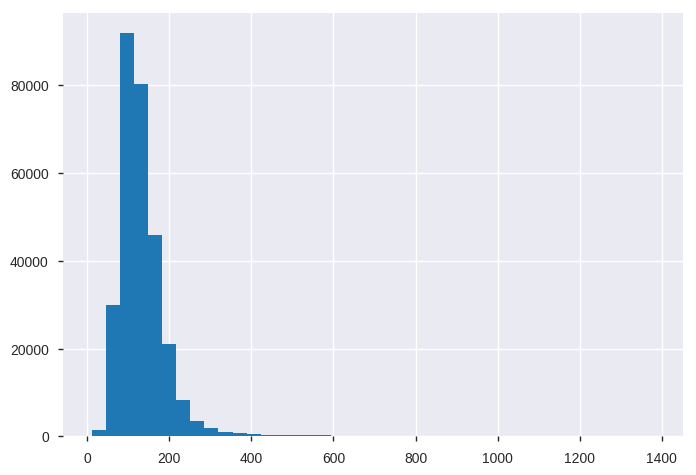

In [85]:
df_premiums.final_premium.hist(bins=40)

In [86]:
df_premiums = get_premiums(X_test, X_test_sev, freq_glm_fitted, sev_glm_fitted, 0.30)
df_premiums['Claim_amnt'] = flat_data_tr['ClaimAmount']
df_premiums.sum()

base_premium     1.285448e+07
final_premium    1.671082e+07
Claim_amnt       9.200861e+06
dtype: float64

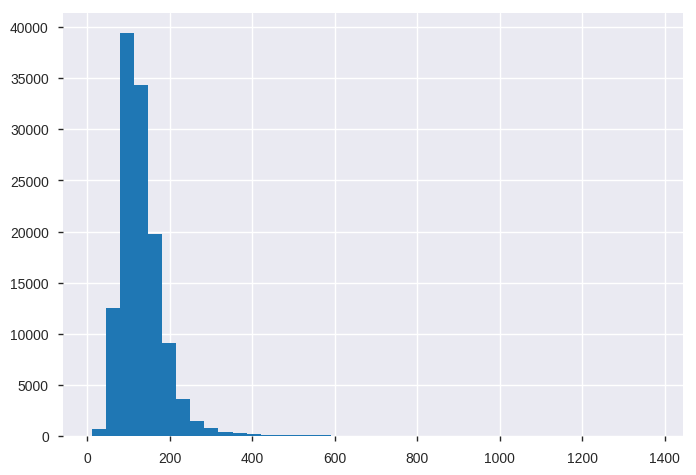

In [87]:
df_premiums.final_premium.hist(bins=40)